# Extrinsics Calibration

In [3]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

from typing import List

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel, Pixel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [15]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "..", "assets", "notebooks", "01.computer-vision")
image_fpath: str = os.path.join(assets_dir, f"image1.jpg")




image_fpath: str = os.path.join(this_dir, "..", "..", "board.jpeg")


image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
      "width": 640,
      "height": 480,
      "K": np.reshape([
            275.73276038498926,
            0.0,
            319.6766909474663,
            0.0,
            280.1548497747509,
            273.2555774703665,
            0.0,
            0.0,
            1.0,
      ], (3, 3)),
      "D": [
            -0.186769174617111,
            0.021237828783060932,
            -0.010063453683894804,
            0.0020176247114933833,
            0.0,
      ],
      "P": np.reshape([
            181.33279418945312,
            0.0,
            321.308646777532,
            0.0,
            0.0,
            230.59254455566406,
            277.2216409396642,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
      ], (3, 4))
}
camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

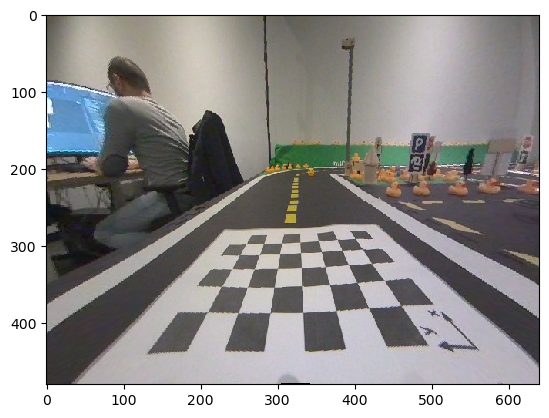

In [16]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [21]:
# find corners
corners: List[Pixel] = find_corners(image, board)

corners = corners[::-1]

print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


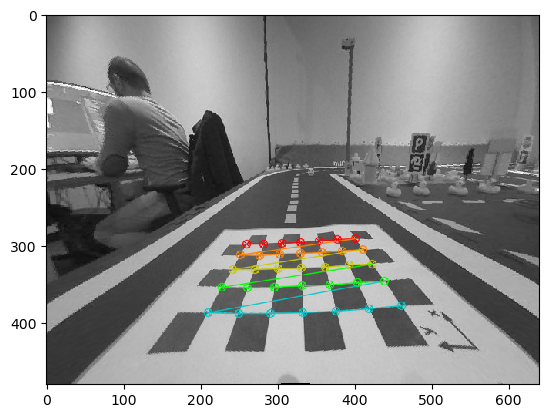

In [22]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [23]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [24]:
# project the principal point onto the plane
ground_pp = np.dot(H, [0, 0, 1])
ground_pp = (ground_pp / ground_pp[2])[:2]
# manually measured when the image above was taken
expected_pp = [0.4, 0]

# compute error estimate
pp_error = np.linalg.norm(ground_pp - expected_pp)
print(f"Error is ~{pp_error * 100:.2f}cm.")

# make sure the error is within 3cm
assert pp_error <= 0.03

Error is ~2.19cm.


In [25]:
print(H)

[[ 0.0219712   0.09045404  0.38400369]
 [-0.44468068  0.01655425  0.01499358]
 [ 0.20360817  2.9932356   1.        ]]


# Ground Reprojection

In [ ]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

# GUI

In [ ]:
from matplotlib.pyplot import figure

from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_gui, top_view_projected_corners
from dt_computer_vision.ground_projection.rendering import draw_grid_image

In [ ]:
fig = figure(figsize=(32, 18), dpi=96)

right = top_view_projected_corners(
    ground_corners,
    errors,
    (560, 480),
    start_y=0.15,
)

gui = draw_gui(image_w_corners, right, len(corners), board, avg_error, placement_error)

gui = cv2.cvtColor(gui, cv2.COLOR_BGR2RGB)
plt.imshow(gui)